In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sber_data = pd.read_csv('data/sber_data.csv')
sber_data.head()

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,0,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,0,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,0,5700000
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,0.934273,0.892674,0.236455,1.031777,1.561505,16.990677,16.041521,good,0,13100000
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,0.077901,0.810801,0.376838,0.378756,0.121681,1.112486,1.800125,excellent,0,16331452


In [3]:
sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

In [4]:
# Найдём число квартир с нулевой жилой площадью:
print(sber_data[sber_data['life_sq'] == 0].shape[0])

45


In [5]:
# А теперь выведем здания с жилой площадью более 7 000 квадратных метров:
display(sber_data[sber_data['life_sq'] > 7000])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


In [6]:
# Давайте проверим это с помощью фильтрации:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
print(outliers.shape[0])

37


In [7]:
# Ещё пример: давайте посмотрим на признак числа этажей (floor).
display(sber_data['floor'].describe())

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

In [8]:
# Снова видим подозрительную максимальную отметку в 77 этажей. Проверим все квартиры, которые находятся выше 50 этажей:
display(sber_data[sber_data['floor']> 50])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
23584,23587,57,33.0,77.0,Lomonosovskoe,3091.0,5,8359.0,7,1,...,0.310557,0.731683,0.489763,0.86354,0.863266,2.920671,2.757058,satisfactory,0,13700000


# Метод межквартильного размаха (метод Тьюки)

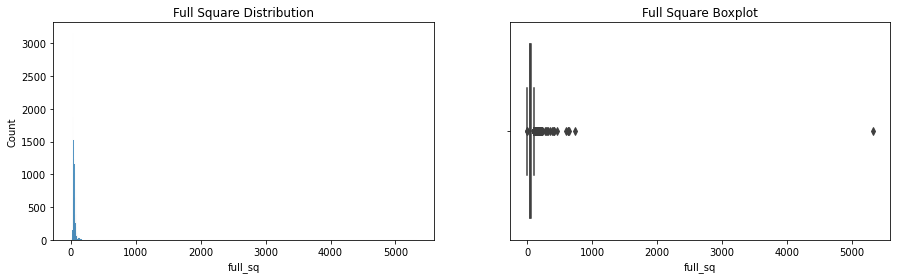

In [9]:
# Построим гистограмму и коробчатую диаграмму для признака полной площади (full_sq):
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0])
histplot.set_title('Full Square Distribution')
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1])
boxplot.set_title('Full Square Boxplot')

In [10]:
# В соответствии с этим алгоритмом напишем функцию outliers_iqr(), которая вам может ещё не раз пригодиться в реальных задачах. Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает потенциальные выбросы, найденные с помощью метода Тьюки, и очищенный от них датасет.
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [11]:
#  Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:
outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


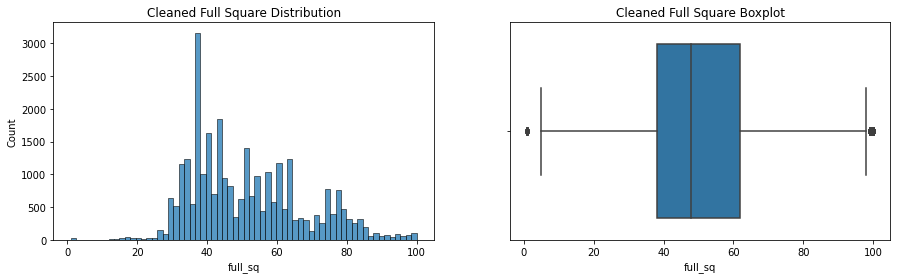

In [13]:
# Согласно классическому методу Тьюки, под выбросы у нас попали 963 записи в таблице. Давайте построим гистограмму и коробчатую диаграмму на новых данных cleaned_sber_data:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [18]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    """
    Давайте немного модифицируем нашу функцию outliers_iqr(). 
    Добавьте в нее параметры left и right, которые задают число IQR влево и вправо от границ ящика (пусть по умолчанию они равны 1.5).
    Функция, как и раньше должна возвращать потенциальные выбросы и очищенный DataFrame.
    """

    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [19]:
# 6.2
outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq', 1, 6)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 59
Результирующее число записей: 30403


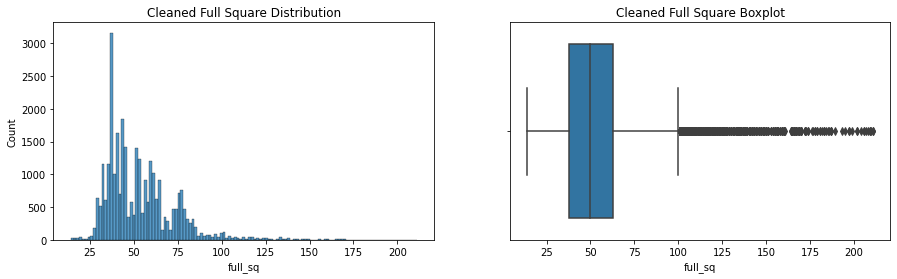

In [20]:
# Если мы построим гистограмму и коробчатую диаграмму на полученных данных, то увидим вот такую картинку:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

# Метод z-отклонений (метод сигм)

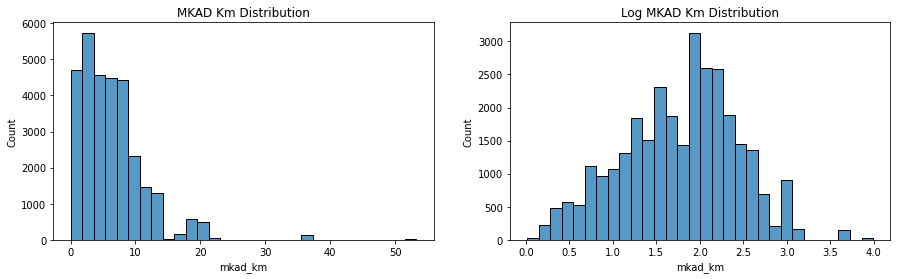

In [21]:
# Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. Логарифмировать будем с помощью функции log() из библиотеки numpy. Признак имеет среди своих значений 0. Из математики известно, что логарифма от 0 не существует, поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

## Давайте реализуем алгоритм метода z-отклонения. Описание алгоритма метода:

→ вычислить математическое ожидание (среднее) и стандартное отклонение признака ;

→ вычислить нижнюю и верхнюю границу интервала как:

→ найти наблюдения, которые выходят за пределы границ.

In [22]:
#  Напишем функцию outliers_z_score(), которая реализует этот алгоритм. 
#На вход она принимает DataFrame и признак, по которому ищутся выбросы. В дополнение добавим в функцию возможность работы в логарифмическом масштабе: для этого введём аргумент log_scale. Если он равен True, то будем логарифмировать рассматриваемый признак, иначе — оставляем его в исходном виде.

def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned


In [23]:
# Применим эту функцию к таблице sber_data и признаку mkad_km, а также выведем размерности результатов:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


In [24]:
# Итак, метод z-отклонения нашел нам 33 потенциальных выброса по признаку расстояния до МКАД. Давайте узнаем, в каких районах (sub_area) представлены эти квартиры:
print(outliers['sub_area'].unique())

['Poselenie Rogovskoe' 'Poselenie Kievskij']


In [26]:
# 6.3
import pandas as pd
import numpy as np

def outliers_z_score_mod(data, feature, log_scale=False, left = 3, right = 3):
    """
    Давайте расширим правило 3ех сигм, чтобы иметь возможность учитывать ассиметричность данных.
    Добавьте в функцию outliers_z_score() параметры left и right, которые будут задавать число сигм (стандартных отклонений) 
    влево и вправо соответственно, которые определяют границы метода z-отклонения. 
    По умолчанию оба параметры равны 3
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [28]:
# 6.4
outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', log_scale=True, left = 3, right= 3.5)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 30471


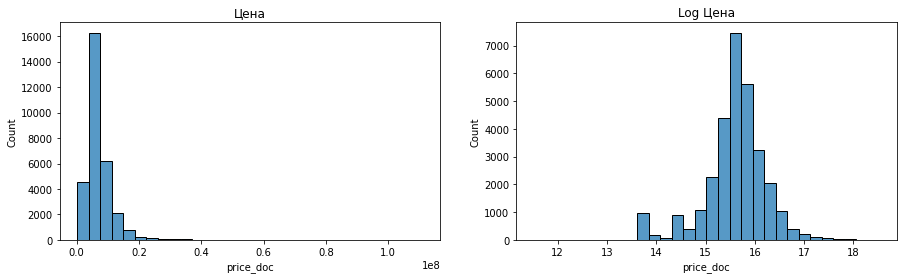

In [29]:
# 6.5
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['price_doc'], bins=30, ax=axes[0])
histplot.set_title('Цена');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log Цена');

In [30]:
# 6.6
outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', log_scale=True, left = 3, right= 3.7)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 68
Результирующее число записей: 30403


In [35]:
# 6.7
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5):
    """
    Давайте немного модифицируем нашу функцию outliers_iqr(). 
    Добавьте в нее параметры left и right, которые задают число IQR влево и вправо от границ ящика (пусть по умолчанию они равны 1.5).
    Функция, как и раньше должна возвращать потенциальные выбросы и очищенный DataFrame.
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [37]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', log_scale=True, left = 3, right= 3)
print(f'Число выбросов по методу IQR-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу IQR-отклонения: 92
Результирующее число записей: 30379
